<a href="https://colab.research.google.com/github/priya1cvr/Hands-ON-ML/blob/main/1.1_Car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 1. Downloading Car Dataset

In [ ]:
! pip install -q kaggle

In [181]:
from google.colab import files
#files.upload()

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d CooperUnion/cardataset

  0% 0.00/103k [00:00<?, ?B/s]
100% 103k/103k [00:00<00:00, 46.5MB/s]


In [8]:
! unzip cardataset.zip

Archive:  cardataset.zip
  inflating: data.csv                


#### 2. Exploratory data analysis

We look at the dataset to learn:
+ The distribution of the target variable
+ The features in this dataset
+ The distribution of values in these features
+ The quality of the data
+ The number of missing values

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [111]:
cars_df = pd.read_csv('data.csv')

In [112]:
print(cars_df.shape)
cars_df.head()

(11914, 16)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [113]:
## normalizing column names i.e: replace all spaces with underscores and lowercase all letters
cars_df.columns = cars_df.columns.str.lower().str.replace(' ','_')

#Select only columns with string values
string_columns = list(cars_df.dtypes[cars_df.dtypes=='object'].index)

for col in string_columns:
  #Lowercase and replace spaces with underscores for values in all string columns of the dataframe.
  cars_df[col] = cars_df[col].str.lower().str.replace(' ','_')

In [114]:
cars_df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


#### **2.2.1** Target variable analysis

The **MSRP** column contain the important information — it’s our target variable, the y, which is the value that we want to learn to predict.

Let's see how target variable looks like

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


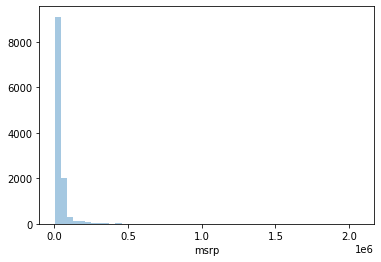

In [115]:
sns.distplot(cars_df.msrp,kde=False)

distribution of prices has a very long tail. There are many cars with low prices on the left side, but the number quickly drops, and there’s a long tail of very few cars with high prices.

We can have a closer look by zooming in a bit and looking at values below $100,000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


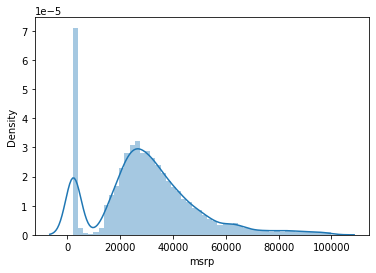

In [116]:
sns.distplot(cars_df[cars_df['msrp']<100000]['msrp'])

Looking only at car prices below 100,000  allows us to see the head of the distribution better. We also notice a lot of cars that cost $1,000.


The long tail makes it quite difficult for us to see the distribution, but it has an even stronger effect on a model: such distribution can greatly confuse the model, so it won’t learn well enough. <br>
One way to solve this problem is log transformation. If we apply the log function to the prices, it removes the undesired effect

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


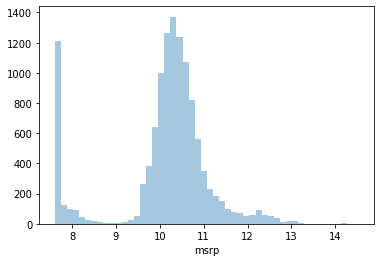

In [117]:
#y_new = log(y+1)
# +1 part in cases that have zeros 
log_price = np.log1p(cars_df.msrp)
sns.distplot(log_price,kde=False)

The transformation removes the long tail, and now the distribution resembles a bell-shaped curve. <br>
This distribution is not normal, of course, because of the large peak in lower prices, but the model can deal with it more easily

#### **2.2.2** Checking for missing values

In [118]:
cars_df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

MSRP — our target variable — doesn’t have any missing values. <br>
market_category, in which we have almost 4,000 rows with missing values.

#### **2.2.3** Validation framework

We should set up the validation framework as early as possible to make sure that the models we train are good and can generalize.
<br> To do this we split the data into training, test and validation set <br>
Let’s split the dataframe such that:<br>
+ 20% of data goes to validation,
+ 20% goes to test, and
+ the remaining 60% goes to train 

In [119]:
## Splitting Data into validation, test, and training sets
## without sklearn

n = len(cars_df)
n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = n - (n_val + n_test)
print(f"n= {n},n_val= {n_val},n_test= {n_test}, n_train= {n_train}".format(n,n_val,n_test,n_train))
np.random.seed(2)
idx = np.arange(n) # Create a NumPy array with indices from 0 to (n-1) and shuffle it.
np.random.shuffle(idx )  # shuffle indexes 
cars_shuffled = cars_df.iloc[idx] # Use the array with indices to get a shuffled dataframe.

df_train = cars_shuffled.iloc[:n_train].copy()
df_val = cars_shuffled[n_train: n_train+n_val].copy()
df_test = cars_shuffled[n_train+n_val: ].copy()


n= 11914,n_val= 2382,n_test= 2382, n_train= 7150


In [120]:
## Applying log transformation to long tailed values of target in each set 
y_train = np.log1p(df_train.msrp.values) 
y_val = np.log1p(df_val.msrp.values) 
y_test = np.log1p(df_test.msrp.values)

In [121]:
## To avoid accidentally using the target variable later, let’s remove it from the dataframes:
del df_train['msrp'] 
del df_val['msrp'] 
del df_test['msrp']

#### 2.3 Training linear regression model

To implement the normal equation, we need to do the following:
1. Create a function that takes in a matrix X with features and a vector y with the target. 
2. Add a dummy column (the feature that is always set to 1) to the matrix X.
3. Train the model: compute the weights w by using the normal equation.
4. Split this w into the bias w0 and the rest of the weights, and return them.

y_pred = w0 + X.dot(w)

In [122]:
def linear_regression(X,y):
  # adding dummy column
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones,X])

  # normal equation
  XTX = X.T.dot(X)
  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)
  return w[0], w[1:]

#### 2.4 Predicting the price

Start with a very naive way of creating features: select a few numerical features and form the matrix X from them. 

In [123]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
dtype: object

In EDA we found dataset has missing values. <br>
We need to do something because the linear regression model cannot deal with missing values automatically.<br> 
Dropping all the rows - will lose the information that we have in the other columns.<br>
Filling the missing values with some other value - we don’t lose the information in other columns and still can make predictions 

In [124]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]

In [125]:
df_num = df_num.fillna(0)
#This method may not be the best way to deal with missing values, but often, it’s good enough.

## Lets convert this df to numpy array 
X_train = df_num.values
print("Type of X_train is: ",type(X_train))

Type of X_train is:  <class 'numpy.ndarray'>


In [126]:
X_train.shape,y_train.shape

((7150, 5), (7150,))

In [127]:
## get the intercept and slope 
w_0, w = linear_regression(X_train,y_train)

In [128]:
# y_pred = w0 + X.dot(w)
y_pred = w_0 + X_train.dot(w)

In [129]:
y_pred

array([ 9.54792783,  9.38733977,  9.67197758, ..., 10.30423015,
       11.9778914 ,  9.99863111])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

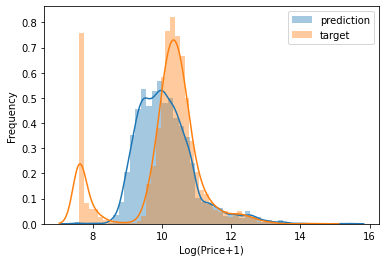

In [130]:
## see how good the predictions are
sns.distplot(y_pred, label='prediction') 
sns.distplot(y_train, label='target') 
plt.legend()
plt.xlabel('Log(Price+1)')
plt.ylabel('Frequency')

+ We can see from the plot that the distribution of values we predicted looks quite different from the actual values. <br>
+ This implies model is not powerful enough to capture the distribution of the target variable.

#### **2.4.1** RMSE: evaluating model quality
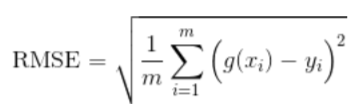

In [131]:
def rmse(y,y_pred):
  error = y_pred - y
  mse = (error ** 2).mean()
  return np.sqrt(mse)

In [132]:
# use RMSE to evaluate the quality of the model:
rmse(y_train,y_pred)

0.7554192603920132

This number tells us that on average, the model’s predictions are off by 0.75. <br>
This result alone may not be very useful, but we can use it to compare this model with other models. <br>
<font color ='green'> If one model has a better (lower) RMSE than the other, it indicates that this model is better.</font>

#### **2.4.2** Validating the model

In [133]:
## Creating X_val same as X_train 
df_num = df_val[base]
df_num = df_num.fillna(0)
X_val = df_num.values

In [134]:
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred)

0.761653099130158

The value this code prints is 0.76, which is the number we should use for comparing models. <br>
As we wrote the same code twice for X_train and X_Val thus put it in a function and avoid duplicating code.

In [135]:
def prepare_X(df):
  df_num = df[base]
  df_num = df_num.fillna(0) 
  X = df_num.values
  return X

In [136]:
X_train = prepare_X(df_train)  
w_0, w = linear_regression(X_train, y_train) 

X_val = prepare_X(df_val) 
y_pred = w_0 + X_val.dot(w)  
print('validation:', rmse(y_val, y_pred))

validation: 0.761653099130158


#### **2.4.3** Simple feature engineering

To improve our model further, we can add more features to the model: we create others and add them to the existing features. <br>
This process is called **feature engineering.** <br>
**Aim is to improve the RMSE calculated on the validation data.**

create a new feature, age, from the feature "year" i.e. the newer the car, the more expensive it should


In [137]:
def prepare_X(df):
  df = df.copy()
  features = base.copy()

  df['age'] = 2017 - df.year
  features.append('age')
  
  df_num = df[features]
  df_num = df_num.fillna(0) 
  X = df_num.values
  return X

In [138]:
X_train = prepare_X(df_train)  
w_0, w = linear_regression(X_train, y_train) 

X_val = prepare_X(df_val) 
y_pred = w_0 + X_val.dot(w)  
print('validation:', rmse(y_val, y_pred))

validation: 0.5172055461058312


The validation error is 0.517, which is a good improvement from 0.76 — the value we had in the baseline solution. <br>
Thus, we conclude that adding age is indeed helpful when making predictions.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

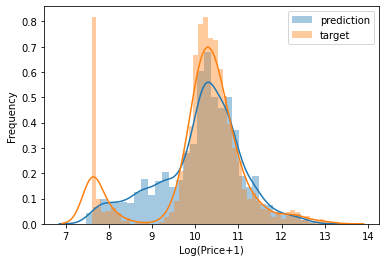

In [139]:
## see how good the predictions are
sns.distplot(y_pred, label='prediction') 
sns.distplot(y_val, label='target') 
plt.legend()
plt.xlabel('Log(Price+1)')
plt.ylabel('Frequency')

#### **2.4.4** Handling categorical variables

Let’s continue adding more features 
+ number of doors seems like integer but it takes only 3 values i.e 2,3,4. Its not really numberic as we can't say that by adding one more door, the price of a car grows (or drops)
+ Categorical variables describe characteristics of objects and takes few possible values . for e.g. make of car (BMW,Toyota,Ford etc) 
+ So, encode such variables by a set of binary features, with a separate feature for each distinct value. This method of encoding categorical variables is called **one-hot encoding**
+ We can use a few more variables: engine_fuel_type, transmission_type,  driven_wheels, market_category, vehicle_size, and vehicle_style. 

In [140]:
cars_df['number_of_doors'].value_counts()

4.0    8353
2.0    3160
3.0     395
Name: number_of_doors, dtype: int64

In [141]:
list(cars_df['number_of_doors'].unique())

[2.0, 4.0, 3.0, nan]

In [142]:
# It should be enough to get and use only the most frequently occurring values for make column
cars_df['make'].value_counts().head(5)

chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
Name: make, dtype: int64

In [143]:
cars_df['engine_fuel_type'].value_counts().head(5)

regular_unleaded                  7172
premium_unleaded_(required)       2009
premium_unleaded_(recommended)    1523
flex-fuel_(unleaded/e85)           899
diesel                             154
Name: engine_fuel_type, dtype: int64

In [170]:
def prepare_X(df):
  df = df.copy()
  features = base.copy()

  df['age'] = 2017 - df.year
  features.append('age')

  
  for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']: # taking 5 most frequent
    feature = 'is_make_%s' % v
    df[feature]= (df['number_of_doors']==v).astype(int)
    features.append(feature)

  for v in [2,3,4]:
    feature = 'num_doors_%s' % v
    df[feature]= (df['number_of_doors']==v).astype(int)
    features.append(feature)
  
  for v in ['regular_unleaded', 'premium_unleaded_(required)', 
            'premium_unleaded_(recommended)','flex-fuel_(unleaded/e85)']: 
    feature = 'is_type_%s' % v
    df[feature] = (df['engine_fuel_type'] == v).astype(int) 
    features.append(feature)
  
  for v in ['automatic', 'manual', 'automated_manual']:  
    feature = 'is_transmission_%s' % v
    df[feature] = (df['transmission_type'] == v).astype(int) 
    features.append(feature)
  
  for v in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']: 
    feature = 'is_driven_wheels_%s' % v
    df[feature] = (df['driven_wheels'] == v).astype(int) 
    features.append(feature)

  for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']: 
    feature = 'is_mc_%s' % v
    df[feature] = (df['market_category'] == v).astype(int) 
    features.append(feature)

  for v in ['compact', 'midsize', 'large']: 
    feature = 'is_size_%s' % v
    df[feature] = (df['vehicle_size'] == v).astype(int) 
    features.append(feature)

  for v in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']: 
    feature = 'is_style_%s' % v
    df[feature] = (df['vehicle_style'] == v).astype(int) 
    features.append(feature)
    
  df_num = df[features]
  df_num = df_num.fillna(0) 
  X = df_num.values
  return X

In [171]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w) 
print('validation:', rmse(y_val, y_pred))

LinAlgError: ignored

#### **2.4.5** Regularization

+ It is found that adding new features does not always help, and in our case, it made things a lot worse.The reason for this behavior is **numerical instability** <br>
As w = [X.T.dot(X) ]^-1.(X.T).y
+ The inversion is the issue in our case. Sometimes, when adding new columns to X, we can accidentally add a column that is a combination of other columns.
+ It happened because we don’t typically have columns that are perfect linear combinations of other columns
+ The real data is often noisy, with measurement errors (such as recording 1.3 instead of 13 for mpg), rounding errors (such as storing 0.0999999 instead of 0.1), and many other errors. 
+ In numerical linear algebra, such issues are called numerical instability issues, and they are typically **solved with regularization techniques**.

<font color ='green'> The aim of regularization is to make sure that the inverse exists by forcing the matrix to be invertible.</font> <br>
Regularization is an important concept : it means “controlling” — controlling the weights of the model so that they behave correctly and don’t grow too large, as in our case.<br><br>
One way to do regularization is to add a small number to each diagonal element of the matrix. 

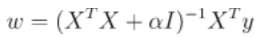

In [165]:
## defining normal equation as above
def linear_regression_reg(X,y,r=0.0):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones,X])

  XTX = X.T.dot(X)
  # r =0 means unregularized 
  reg = r* np.eye(XTX.shape[0])
  XTX = XTX + reg 
  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)
  return w[0],w[1:]


In [169]:
#Let’s check what happens with our weights for different values of r:
for r in [ 0.001, 0.01, 0.1, 1, 10]:
  w_0, w = linear_regression_reg(X_train, y_train, r=r) 
  print('%5s, %.2f, %.2f' % (r, w_0, w[13]))

0.001, 10.66, -1.30
 0.01, 10.63, -1.28
  0.1, 10.40, -1.06
    1, 9.00, 0.23
   10, 6.88, 1.84


In [172]:
X_train = prepare_X(df_train)
w_0, w = linear_regression_reg(X_train, y_train,r=0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w) 
print('validation:', rmse(y_val, y_pred))

validation: 0.4620295899280206


This result is an improvement over the previous score: 0.517.

**NOTE**: Sometimes, when adding a new feature causes performance degradation, simply removing this feature may be enough to solve the problem. Having a validation dataset is important to decide whether to add regularization, remove the feature, or do both: we use the score on the validation data to choose the best option.

In [173]:
## run a grid search to select the best parameter r:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]: 
  w_0, w = linear_regression_reg(X_train, y_train, r=r) 
  y_pred = w_0 + X_val.dot(w)
  print('%6s' %r, rmse(y_val, y_pred))

 1e-06 0.46202820041894105
0.0001 0.4620284194712546
 0.001 0.4620295899280206
  0.01 0.4620413352902923
   0.1 0.4621620495157536
     1 0.46352621855653553
     5 0.46973183198498675
    10 0.47663797354590093


We also notice that the performance for values below 0.1 don’t change much except in the sixth digit, which we shouldn’t consider to be significant.
<br><br>
Let’s take the model with r=0.01 as the final model and check against test set.

In [175]:
X_train = prepare_X(df_train)
w_0, w = linear_regression_reg(X_train, y_train,r=0.01)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w) 
print('validation:', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w) 
print('test:', rmse(y_test, y_pred))


validation: 0.4620413352902923
test: 0.45973038326005505


Because these two numbers are pretty close, we conclude that the model can generalize well to the new unseen data.

As we now have a model, we can start using it for predicting the price of a car. <br>
Suppose that a user posts the following ad on the website:<br>
ad = {
'city_mpg': 18,
'driven_wheels': 'all_wheel_drive', 'engine_cylinders': 6.0, 'engine_fuel_type': 'regular_unleaded', 'engine_hp': 268.0,
'highway_mpg': 25,
'make': 'toyota',
'market_category': 'crossover,performance', 'model': 'venza',
'number_of_doors': 4.0,
'popularity': 2031,
'transmission_type': 'automatic', 'vehicle_size': 'midsize',
'vehicle_style': 'wagon',
'year': 2013
}

We suggest the price for this car and so use our model

In [176]:
ad = {
    'city_mpg': 18,
'driven_wheels': 'all_wheel_drive', 'engine_cylinders': 6.0, 'engine_fuel_type': 'regular_unleaded', 'engine_hp': 268.0,
'highway_mpg': 25,
'make': 'toyota',
'market_category': 'crossover,performance', 'model': 'venza',
'number_of_doors': 4.0,
'popularity': 2031,
'transmission_type': 'automatic', 'vehicle_size': 'midsize',
'vehicle_style': 'wagon',
'year': 2013
}

In [177]:
df_test = pd.DataFrame([ad])
X_test = prepare_X(df_test)
X_test

array([[2.680e+02, 6.000e+00, 2.500e+01, 1.800e+01, 2.031e+03, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]])

In [179]:
y_pred = w_0 + X_test.dot(w)
y_pred

array([10.36471506])

In [180]:
## This prediction is not the final price, however; it's the logarithm of the price. 
## To get the actual price, we need to undo the logarithm and apply the exponent function:

suggestion = np.expm1(y_pred) 
suggestion

array([31719.39267606])